In [1]:
%matplotlib inline

In [2]:
import functools
import itertools

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from scipy.special import logit, expit

def train_test_split(X, y, train_size=.9, seed=1):
    np.random.seed(seed)
    indices = np.arange(X.shape[0], dtype=int)
    np.random.shuffle(indices)
    train_size = int(X.shape[0] * train_size)
    train_indices, test_indices = indices[:train_size], indices[train_size:]
    return X[train_indices], y[train_indices], X[test_indices], y[test_indices]


def accuracy_score(clf, X, y):
    return (clf.predict(X) == y).mean()


def k_fold_split(X, y, k, seed=1):
    np.random.seed(seed)
    indices = np.arange(X.shape[0], dtype=int)
    np.random.shuffle(indices)
    test_size = int(X.shape[0] / k)
    for i in range(0, X.shape[0], test_size):
        train_indices = np.concatenate([indices[:i], indices[i + k:]])
        test_indices = indices[i:i + test_size]
        yield X[train_indices], y[train_indices], X[test_indices], y[test_indices]


def k_fold(clf, X, y, k, seed=1):
    test_errors = np.array([
        accuracy_score(clf.fit(train_X, train_y), test_X, test_y)
        for train_X, train_y, test_X, test_y in k_fold_split(X, y, k, seed)
    ])

    return test_errors.mean(), test_errors.std() #, test_errors


In [3]:
def loss(w, X, y, l): 
    """Logistic loss function with Tikhonov regularization."""
    return np.log(1 + np.exp(-y * X.dot(w))).mean() + l * (w[:1] ** 2).sum()

def loss_grad(w, X, y, l): 
    grad = (- X * (y * expit(-y * X.dot(w))).reshape(-1, 1)).mean(axis=0)
    grad[:-1] += 2 * l * w[:-1]
    return grad

def bgd(grad_f, w_init, n_steps, eta=.1): 
    """Batch gradient descent algorithm."""
    w = w_init.copy()
    for i in range(n_steps):
        w -= eta * grad_f(w)        
    return w

In [4]:
class LogisticRegression: 
    def __init__(self, l, eta, solver='sgd', n_steps=1000): 
        self.lambda_ = l
        self.n_steps = n_steps
        self.solver = solver
        self.eta = eta
        
    def fit(self, X, y): 
        X_ = np.hstack([X, np.ones((X.shape[0], 1))])
        
        w_ = np.zeros(X_.shape[1])
        if self.solver != 'sgd':
            w_ = bgd(functools.partial(loss_grad, X=X_, y=y, l=self.lambda_), 
                     w_, self.n_steps, eta=self.eta)
        else:
            for i, (_x, _y) in zip(range(self.n_steps), itertools.cycle(zip(X_, y))):
                w_ -= self.eta * loss_grad(w_, 
                                           _x.reshape((1, -1)), 
                                           _y.reshape((1, 1)), 
                                           self.lambda_)
        self.coef_ = w_[:-1]
        self.intercept_ = w_[-1]
        return self

    def predict(self, X): 
        return (self.predict_proba(X) > 0) * 2 - 1
    
    def predict_proba(self, X): 
        return X.dot(self.coef_) + self.intercept_

    @property 
    def w(self): 
        return np.hstack([self.coef_, self.intercept_])

In [5]:
df = pd.read_csv('iris.data', index_col=False, names='sl sw pl pw type'.split())
X = df.as_matrix(columns=df.columns[:-1])
X_train, y_train, X_val, y_val = train_test_split(X, df.type, train_size=.9, seed=5)

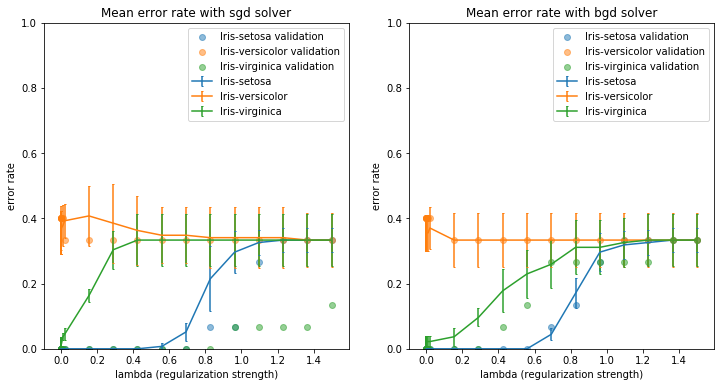

In [7]:
fig = plt.figure(figsize=(12, 6))

n_steps = 20000
eta = .0015
lambdas = np.hstack([
    np.logspace(-6, -2, 7),
    np.linspace(.02, 1.5,  12)
])
solvers = ['sgd', 'bgd']

for i, solver in enumerate(solvers):
    plt.subplot(1, 2, i+1)
    
    for j, kind in enumerate(df.type.unique()): 
        y = np.array(y_train == kind) * 2 - 1
        
        result = np.array([
            k_fold(LogisticRegression(l=l, eta=eta, n_steps=n_steps, solver=solver), 
                   X=X_train, y=y, k=3)
            for l in lambdas
        ])
        
        plt.errorbar(lambdas, 1-result[:, 0], result[:, 1], label=kind, capsize=1)
        
#       for insight, not for model selection
        validation_scores = [
                1 - accuracy_score(
                LogisticRegression(l=l, eta=eta, n_steps=n_steps, solver=solver).fit(X_train, y),
                X_val, (y_val==kind) * 2 - 1)
            for l in lambdas 
        ]
        plt.scatter(lambdas, validation_scores, label='{} validation'.format(kind), alpha=.5)
    
    plt.xlabel('lambda (regularization strength)')
    plt.ylabel('error rate')
    plt.ylim(0, 1)
    plt.legend(loc=1)
    plt.title("Mean error rate with {} solver".format(solver))

Данная задача является выпуклой, а, значит, оба рассмотренных алгоритма оптимизации сходятся к точке менимума, и основная трудность в выборе параметров оптимизации. 

Преимуществом стохастического градиентного спуска является меньшее потребление памяти и, как правило, ему необходимо меньшее количество "проходов" по обучающей выборке для нахождения решения *близкого* к оптимальному. 